In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout

# 1. Getting data

- gas-drift.npz

Dataset includes:

* `x` : training data (all are normal samples)
* `tx` : test data samples (some normal, some abnormal)
* `ty` : tells you which are normal and which are not.
  * our autoencoder would reconstruct every sample with
ty=0 very well, and make mistakes when ty=1

In [2]:
# This code allows us to upload data from local drive
from google.colab import files
uploaded = files.upload()

Saving gas-drift.npz to gas-drift.npz


In [3]:
data = np.load('gas-drift.npz')

In [4]:
print(data.files)

['x', 'tx', 'ty']


In [5]:
X_tra = data['x']
X_te = data['tx']
y_test= data['ty']

In [6]:
X_tra

array([[ 1.02207805e+05,  7.69728518e+00,  3.22496986e+01, ...,
        -1.14370394e+01, -1.95989666e+01, -3.78004646e+01],
       [ 7.41178203e+04,  1.29636126e+01,  2.27694302e+01, ...,
        -7.30788803e+00, -1.14536076e+01, -1.82232208e+01],
       [ 1.05811102e+05,  1.64511414e+01,  3.18421764e+01, ...,
        -1.03243752e+01, -1.76909103e+01, -3.05263653e+01],
       ...,
       [ 1.53187305e+04,  2.95657301e+00,  6.43087101e+00, ...,
        -1.39576805e+00, -2.19809008e+00, -5.28260612e+00],
       [ 7.81490078e+04,  2.40627537e+01,  2.26935921e+01, ...,
        -7.78919315e+00, -1.21613359e+01, -1.66698265e+01],
       [ 4.60642305e+04,  1.08739367e+01,  1.37828798e+01, ...,
        -5.26023293e+00, -8.17412758e+00, -1.48764477e+01]], dtype=float32)

In [7]:
y_test.shape

(1538,)

In [8]:
X_tra.shape

(1796, 128)

In [9]:
X_te.shape

(1538, 128)

In [10]:
X_tra.min()

-4839.4463

In [11]:
X_tra.max()

231364.17

# 2. Feature scaling
- Using MinMaxScaler() in Scikit-learn to scale data

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_tra.copy())
X_test = scaler.transform(X_te.copy())

# 3. Create Autoencoder Model

In [13]:
# Create a model by subclassing Model class in tensorflow
class Autoencoder(Model):
  """
  An autoencoder with Encoder and decoder blocks and adjustable size of laten space
  
  Arguments:
    input_dim -- number of NN units at layer 0 (input)
    latent -- size of laten space layer
         
  Returns: 
    autoencoder -- autoencoder Model
  """

  def __init__(self, input_dim, latent):
    super().__init__()
    # encoder block
    self.encoder = Sequential([
        Dense(latent * 8, activation='relu'),
        Dropout(0.1),
        Dense(latent * 4, activation='relu'),
        Dropout(0.1),
        Dense(latent * 2, activation='relu'),
        Dropout(0.1),
        Dense(latent, activation='relu')
    ])
    # Decoder block
    self.decoder = Sequential([
        Dense(latent * 2, activation='relu'),
        Dropout(0.1),
        Dense(latent * 4, activation='relu'),
        Dropout(0.1),
        Dense(latent * 8, activation='relu'),
        Dropout(0.1),
        Dense(input_dim, activation='sigmoid')
    ])

  def call(self, inputs):
    encode = self.encoder(inputs)
    decode = self.decoder(encode)
    return decode

## 3.a. Training model using the loss function `Mean Square Error`:

Pros of mse:
  * MSE penalises the model for having huge errors by squaring them.
  * It is particularly helpful in weeding out outliers with large errors from the model by putting more weight on them.

**source:** https://medium.com/analytics-vidhya/loss-functions-to-evaluate-regression-models-8dac47e327e2

In [14]:
def training_model(model_architecture, X_train, X_test, latent = 4, verbose = 0, loss = "mse", epochs=50, batch_size=128):
  """
  training a model

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    X_train  -- input data
    X-test -- test data
    latent -- the size of latent space applied for model_architecture
    loss -- the loss metrics is used for training model
    epochs -- number of training loops
    batch_size
    verbose -- showing progress of trainin model

  Returns:
    autoencoder -- the trained model
    history -- the history of trained model
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)

  # Create autoencoder model
  autoencoder = model_architecture(input_dim=X_train.shape[1], latent = latent)

  # callback will stop the training when there is no improvement in the loss for 3 consecutive epochs
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

  # Loss and optimizer definition
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss=loss,  #  Computes the mean of squares of errors between y_true & y_pred.
                      metrics=[loss]) 

  # Training model
  EPOCHS = epochs
  BATCH_SIZE = batch_size

  # Fit the autoencoder
  history= autoencoder.fit(x=X_train, 
                          y=X_train,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          verbose = verbose,
                          callbacks = [callback],
                          validation_split=0.2,   # Fraction of the training data to be used as validation data
                          shuffle=True)
  return autoencoder, history

## 3.b. Function to measure the performance of model in detecting outlier

https://stackoverflow.com/questions/65398299/proper-inputs-for-scikit-learn-roc-auc-score-and-roc-plot

In [ ]:
def performance(model, X_test, plot = True):
  """
  Measure performance of trained model mit AUC score using built-in function in sklearn

  Arguments:
    model -- trained model
    X_test -- data which are used to test the trained model
    plot -- True: plot the ROC curve. False: does not plot the ROC curve
         
  Returns: 
    AUC -- the AUC score
    ROC curve
  """

  # getting predictions (recontructions) of the test data
  preds = model.predict(X_test)
  # calculate the difference between predictions and test data using mean square error
  pred_errors = tf.keras.losses.mse(preds, X_test)
  # Check the prediction performance
  auc_score = roc_auc_score(y_test, pred_errors)
  if not plot:
    print(f"AUC score: {auc_score}")
  else:
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, pred_errors)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % auc_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
model,_ = training_model(Autoencoder, X_train, X_test, latent = 64, verbose = 0, loss = "mse", epochs=100, batch_size=128)

49/49 [==============================] - 0s 2ms/step


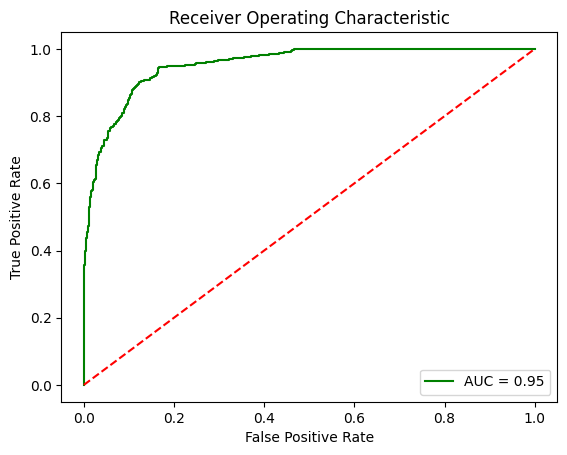

In [ ]:
performance(model, X_test)

## 3.b. Check the effect of laten space on the model.

* After plot the effect of latent size on the models, i come up with the result that we should construct our model as Autoencoder architecture by using the latent space of size 112 for this **gas-drift** dataset
* with latent space of 112, we get AUC = 0.975 by using Autoencoder

In [ ]:
def effect_laten(model_architecture, X_train, X_test, y_test, latent_list, loss = "mse", epochs=50, batch_size=128):
  """
  This function will check the effect of the size of laten space on the model

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    latent_list -- list contains the sizes of laten space that we want to use for our model

  Returns:

  """
  # list contains auc_score of trained models
  auc_list = []
  # training model with different sizes of latent space
  for i in latent_list:
    model, hist = training_model(model_architecture, X_train, X_test, latent = i, loss = loss, epochs=epochs, batch_size=batch_size)

    #getting predictions (recontructions) of the test data
    preds = model.predict(X_test)
    # calculate the difference between predictions and test data using mean square error
    pred_errors = tf.keras.losses.mse(preds, X_test)
    # Check the prediction performance
    auc_score = roc_auc_score(y_test, pred_errors)
    auc_list.append(auc_score)
    print(f"Latent = {i}: AUC score = {auc_score}")

  # plot the effect of latent space on trained models
  plt.plot(latent_list, auc_list)
  plt.title('The effect of latent space on models')
  plt.xlabel("Latent size")
  plt.ylabel("AUC score")
  plt.show()

49/49 [==============================] - 0s 974us/step
Latent = 4: AUC score = 0.8484191551353573
49/49 [==============================] - 0s 991us/step
Latent = 8: AUC score = 0.8813279874729649
49/49 [==============================] - 0s 1ms/step
Latent = 16: AUC score = 0.9206711298174889
49/49 [==============================] - 0s 1ms/step
Latent = 32: AUC score = 0.9348671961796601
49/49 [==============================] - 0s 2ms/step
Latent = 64: AUC score = 0.9564732878901382
49/49 [==============================] - 0s 3ms/step
Latent = 96: AUC score = 0.9733851234694205
49/49 [==============================] - 0s 3ms/step
Latent = 112: AUC score = 0.9753027338630718
49/49 [==============================] - 0s 4ms/step
Latent = 128: AUC score = 0.9121534900001861


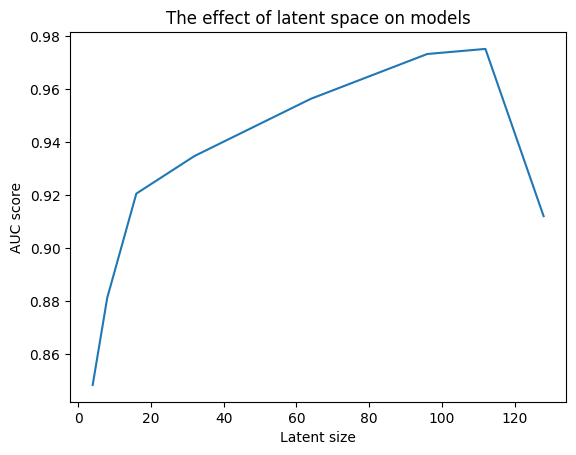

In [ ]:
effect_laten(Autoencoder, X_train, X_test, y_test, latent_list = [4, 8, 16, 32, 64, 96, 112, 128])

# 4.  Test new architecture of model

Adding one more hidden layer in architecture model of Autoencoder. But the result of trained model based on new AutoencoderV2 is worse than Autoencoder. So we use the architecture of Autoencoder


In [ ]:
# AutoencoderV2 is based on Autoencoder architecture with more one hidden layer is added
class AutoencoderV2(Model):
  """
  An autoencoder with Encoder and decoder blocks and adjustable size of laten space
  
  Arguments:
    input_dim -- number of NN units at layer 0 (input)
    latent -- size of laten space layer
         
  Returns: 
    autoencoder -- autoencoder Model
  """

  def __init__(self, input_dim, latent):
    super().__init__()
    # encoder block
    self.encoder = Sequential([
        Dense(latent * 16, activation='relu'),
        Dropout(0.1),
        Dense(latent * 8, activation='relu'),
        Dropout(0.1),
        Dense(latent * 4, activation='relu'),
        Dropout(0.1),
        Dense(latent * 2, activation='relu'),
        Dropout(0.1),
        Dense(latent, activation='relu')
    ])
    # Decoder block
    self.decoder = Sequential([
        Dense(latent * 2, activation='relu'),
        Dropout(0.1),
        Dense(latent * 4, activation='relu'),
        Dropout(0.1),
        Dense(latent * 8, activation='relu'),
        Dropout(0.1),
        Dense(latent * 16, activation='relu'),
        Dropout(0.1),
        Dense(input_dim, activation='sigmoid')
    ])

  def call(self, inputs):
    encode = self.encoder(inputs)
    decode = self.decoder(encode)
    return decode

49/49 [==============================] - 0s 994us/step
Latent = 4: AUC score = 0.8657334521552824
49/49 [==============================] - 0s 1ms/step
Latent = 8: AUC score = 0.8770074455366518
49/49 [==============================] - 0s 1ms/step
Latent = 16: AUC score = 0.9068234124333527
49/49 [==============================] - 0s 2ms/step
Latent = 32: AUC score = 0.9494014654331279
49/49 [==============================] - 0s 3ms/step
Latent = 64: AUC score = 0.9626962210899941
49/49 [==============================] - 0s 7ms/step
Latent = 96: AUC score = 0.9732752075297492
49/49 [==============================] - 0s 8ms/step
Latent = 112: AUC score = 0.9658922384127462
49/49 [==============================] - 1s 10ms/step
Latent = 128: AUC score = 0.9738619895461486


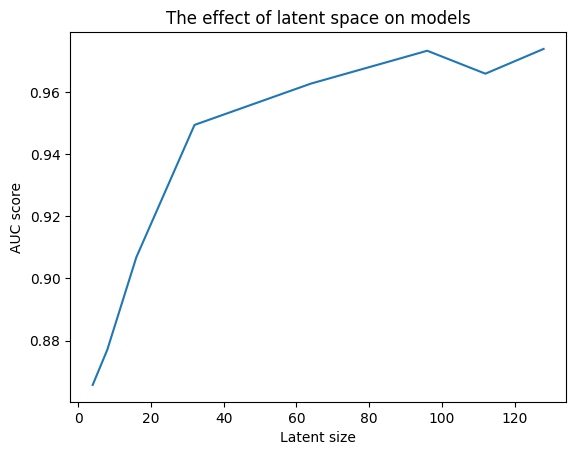

In [ ]:
effect_laten(AutoencoderV2, X_train, X_test, y_test, latent_list = [4, 8, 16, 32, 64, 96, 112, 128])

# 5. Ensemble Model

Build not only a single autoencoder, but an ensemble of them: 

  * first build multiple autoencoder (in a loop)
  * then average their anomaly scores (first calculate the difference between inputs and theirs predictions, then average it)
  * Calculate the final auc score

Then create a plot, showing how this final auc score depends on the
number of models used.


*Example for using tf.math.reduce_mean()*: https://i0.wp.com/www.datasciencelearner.com/wp-content/uploads/2021/08/Mean-of-tensor-of-Multi-dimensional-row-wise.jpg?ssl=1

In [ ]:
def ensemble_model(model_architecture, latent, seed_list, X_train, X_test, y_test, plot=True):
  """
  Create an ensemble model, which use an unique architecture, but with different numbers of random seed. 
  By setting a different random seed, we get a new model with the same architecture

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    latent -- size of latent space of model_architecture
    seed_list -- a list of numbers which are used to set random seed for the model
    X_train -- data which are used to train the model
    X_test -- data which are used to test the trained model
    y_test -- true labels of X_test
    plot -- True: plot the ROC curve. False: does not plot the ROC curve
         
  Returns: 
    avg_preds -- the average of predictions errors (the difference between inputs and their predictions) of all models in ensemble model
    auc_score -- the AUC score of ensemble model
    ROC curve
  """

  # list of pred_errors. Each element contains all the difference between inputs and their predictions of one model
  pred_errors_list = []

  for SEED in seed_list:
    # Set random seed
    tf.keras.utils.set_random_seed(SEED)

    # Create autoencoder model
    autoencoder, history = training_model(model_architecture, X_train, X_test, latent = latent, verbose = 0, loss = "mse", epochs=50, batch_size=128)
    
    # getting predictions (recontructions) of the test data
    preds = autoencoder.predict(X_test)
    # calculate the difference between preds and test data using mean square error
    pred_errors = tf.keras.losses.mse(preds, X_test)
    # append pred_error to the pred_errors_list
    pred_errors_list.append(pred_errors)
  
  # convert pred_errors_list to a tensor
  preds_tensor = tf.convert_to_tensor(pred_errors_list)
  # calculate the average of all pred_errors in the pred_errors_list. We set axis=0, so that the average is calculated by row-weise. 
  avg_preds = tf.math.reduce_mean(preds_tensor, axis=0)
  # AUC score of the average pred_errors of all models vs. y_test
  auc_score = roc_auc_score(y_test, avg_preds)
  if not plot:
    print(f"AUC score: {auc_score}")
  else:
    preds = autoencoder.predict(X_test)
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, avg_preds)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % auc_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
  
  return auc_score, avg_preds

## 5.1. Test ensemble with latent space 96 and using Autoencoder as architecture

49/49 [==============================] - 0s 3ms/step


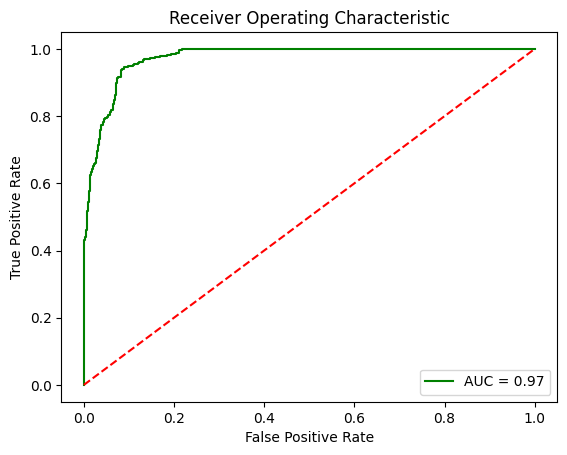

In [ ]:
# Initializing a list of SEED 
SEED_LIST = [i for i in range(6, 12)]
auc_score, avg_preds = ensemble_model(Autoencoder, 96, SEED_LIST, X_train, X_test, y_test, plot=True)

## 5.2. Test ensemble with latent space 112 and using Autoencoder as architecture

49/49 [==============================] - 0s 3ms/step


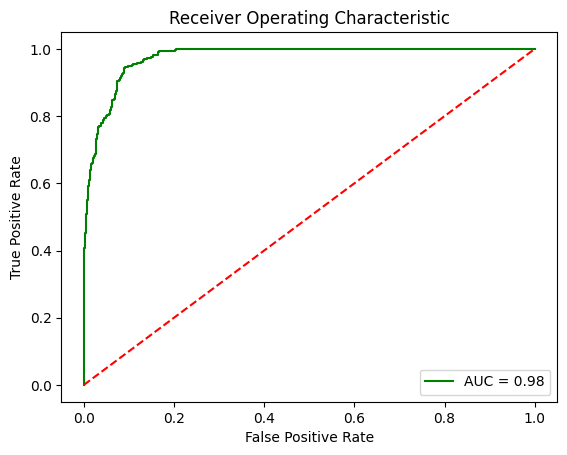

In [ ]:
#Initializing a list of SEED 
SEED_LIST = [i for i in range(6, 12)]
auc_score, avg_preds = ensemble_model(Autoencoder, 112, SEED_LIST, X_train, X_test, y_test, plot=True)

In [ ]:
def plot_auc_models(model_architecture, latent, num_models_list, X_train, X_test, y_test):
  """
  create a plot, showing how this final auc score of ensemble model depends on the number of models used.

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    latent -- size of latent space of model_architecture
    num_models_list -- a list contains the number of models which are integrated in one ensemble model
    X_train -- data which are used to train the model
    X_test -- data which are used to test the trained model
    y_test -- true labels of X_test
         
  Returns: 
    ROC curve
  """

  # list of auc score corresponding with the number of models integrated in an ensemble model
  AUC_LIST = []

  for i in num_models_list:
    # Create a random list of seed
    seed_list = np.random.randint(10, size=i).tolist()
    # Get the auc_score of the ensemble model which is trained by using seed_list
    auc_score, avg_preds = ensemble_model(model_architecture, latent, seed_list, X_train, X_test, y_test, plot=False)
    AUC_LIST.append(np.round(auc_score, 3))

  # the plot display the correlation between auc score and the number of models integrated in an ensemble model
  plt.plot(num_models_list, AUC_LIST, 'g')
  plt.title('Correlation between AUC score and the number of autoencoders in an ensemble model')
  plt.xlabel('the number of autoencoders in an ensemble model')
  plt.ylabel('AUC score of ensembel models')
  plt.show()


49/49 [==============================] - 0s 5ms/step
AUC score: 0.9753027338630718
49/49 [==============================] - 0s 3ms/step
AUC score: 0.9753027338630718
49/49 [==============================] - 0s 3ms/step
AUC score: 0.9753027338630718
49/49 [==============================] - 0s 3ms/step
AUC score: 0.9753027338630718


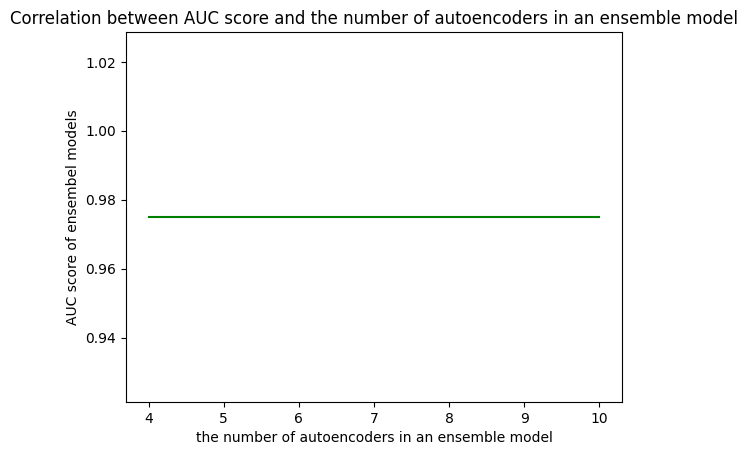

In [ ]:
np.random.seed(0)
plot_auc_models(Autoencoder, 112, [4, 6, 8, 10], X_train, X_test, y_test)

* After testing with different number of models in one ensemble, we see that the result of AUC score of ensembles are not really improved. They are even worse. One reason is that all models in one ensemble are quite similar or can be even identical. Because we changed only the seed number of each model in ensemble. So all models in one ensemble are high correlated with each other.

# 6. Synchronizing ensembles

Example of tf.reduce_mean for columns: https://i0.wp.com/www.datasciencelearner.com/wp-content/uploads/2021/08/Mean-of-tensor-of-Multi-dimensional-column-wise.jpg?ssl=1

## 6.1. sequential_synchronizing

All prediction errors of previous models are used as features in the data used to train the next model. 


In [ ]:
def sequential_synchronizing(model_architecture, latent, num_models, X_train, X_test, y_test, plot=True):
  """Create a sequential syschronizing ensemble, in which the error of the all previous models will be used as features in the data used to train the next model.
  AUC score is calculated by using the error predictions of the last sychronized model

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    latent - latent space size 
    num_models -- the number of models which are integrated in one sychronizing ensemble model
    X_train -- data which are used to train the model
    X_test -- data which are used to validate the model
    plot -- draw ROC curve of all trained models in ensemble
         
  Returns: 
    auc_score_list -- AUC score lists of all models during sychronizing
    avg_pred_errors_list -- list of average pred_errors. Each element contains the average of all the difference between inputs and their predictions of one model
                            each element has shape (X_train.shape[1], 1)
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  # list of pred_errors. Each element contains all the difference between training data and their predictions of one model
  avg_pred_errors_list = []
  # list of test_errors. Each element contains all the difference between test data and their predictions on one model
  test_errors_list = []
  # AUC score list
  auc_score_list = []
  X = X_train.copy()
  X_te = X_test.copy()

  for i in range(num_models):
    # 1. Create model
    # if pred_errors_list is not empty, then we have to concatenate the element at position i-1 to the current training input
    if avg_pred_errors_list:
      # convert the element at position i-1 in pred_errors_list to a 2D-tensor and then convert it to a numpy array. 
      pred_current = tf.reshape(avg_pred_errors_list[i-1], [-1, 1]).numpy()
      # convert the element at position i-1 in test_errors_list to a 2D-tensor and then convert it to a numpy array.
      pred_test_current = tf.reshape(test_errors_list[i-1], [-1, 1]).numpy()
      # concatenate the pred_current to X
      X = np.concatenate((X, pred_current), axis=1)
      # concatenate the pred_current to X_test also. This new X_test will be used for later predict method   
      X_te = np.concatenate((X_te, pred_test_current), axis=1)

    # training model
    autoencoder, history = training_model(model_architecture, X, X_te, latent = latent, verbose = 0, loss = "mse", epochs=50, batch_size=128)

    # getting predictions (recontructions) of the training data
    preds = autoencoder.predict(X)
    # calculate the difference between preds and the training data using (input - preds)**2
    pred_errors = tf.math.square(tf.math.subtract(preds, X))
    # calculate the average of pred_errors. We set axis = 1, so that the average is calculated by column-weise
    avg_preds = tf.math.reduce_mean(pred_errors, axis=1)   # shape = (X_train.shape[1], 1)
    # append avg_preds to the avg_pred_errors_list
    avg_pred_errors_list.append(avg_preds)

    # getting predictions (recontructions) of the test data
    preds_test = autoencoder.predict(X_te)
    # calculate the difference between preds and the test data using (input - preds)**2. These values is used to create a new feature added to the next training loop
    pred_errors_test = tf.math.square(tf.math.subtract(preds_test, X_te))
    # calculate the average of pred_errors_test. We set axis = 1, so that the average is calculated by column-weise
    avg_preds_test = tf.math.reduce_mean(pred_errors_test, axis=1)   # shape = (X_train.shape[1], 1)
    # append avg_preds_test to the test_errors_list
    test_errors_list.append(avg_preds_test)

    # 4. Calculating AUC score of each training model
    # calculate the difference between preds_test and test data. These errors are used to calculate AUC score
    errors_test = tf.keras.losses.mse(preds_test, X_te)
    auc_score = round(roc_auc_score(y_test, errors_test), 3)
    auc_score_list.append(auc_score)

    # 5. Plot ROC Curve
    if plot:
      fpr, tpr, threshold = roc_curve(y_test, errors_test)
      plt.plot(fpr, tpr, label = f'model {i+1}: {auc_score}')
      
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  return auc_score_list, avg_pred_errors_list

49/49 [==============================] - 0s 4ms/step


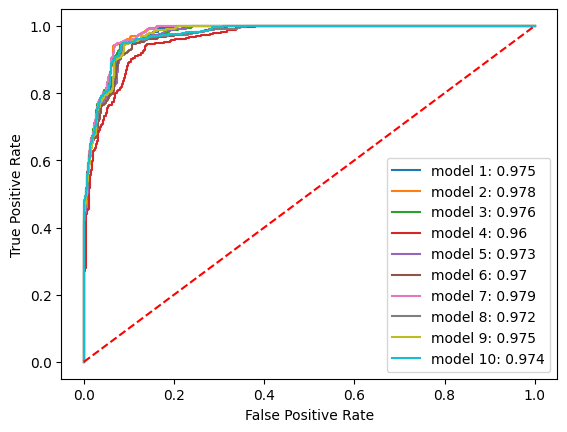

In [ ]:
auc_score_list, avg_pred_errors_list = sequential_synchronizing(Autoencoder, 112, 10, X_train, X_test, y_test)

* By using sequential_synchronising(), we get the best AUC score ist 0.979. This score is improved a little bit im comparision with ensemble model

## 6.2. drop_synchronizing_ensemble

only the prediction errors of the last trained model are used as a feature in the data used to train the next model

In [ ]:
def drop_synchronizing_ensemble(model_architecture, latent, num_models, X_train, X_test, y_test, plot=True):
  """Create a syschronizing ensemble, in which the prediction errors of the last 
  trained model will be added as an feature to the original training data used for the next model.
  AUC score is calculated by using the error predictions of the last sychronized model

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    latent -- latent space size
    num_models -- the number of models which are integrated in one sychronizing ensemble model
    X_train -- data which are used to train the model
    X_test -- data which are used to validate the model
    plot -- draw ROC curve of all trained models in ensemble
         
  Returns: 
    auc_score_list -- AUC score lists of all models during sychronizing
    avg_pred_errors_list -- list of average pred_errors. Each element contains the average of all the difference between inputs and their predictions of one model
                            each element has shape (X_train.shape[1], 1)
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  # list of pred_errors. Each element contains all the difference between inputs and their predictions of one model
  avg_pred_errors_list = []
  test_errors_list = []
  auc_score_list = []
  X_plus_one = X_train.copy()
  X_test_one = X_test.copy()

  for i in range(num_models):
    # 1. Create model
    # if pred_errors_list is not empty, then we have to concatenate the element at position i to the current training input
    if avg_pred_errors_list:
      # convert the element at position i-1 in pred_errors_list to a 2D-tensor and then convert it to a numpy array. 
      pred_current = tf.reshape(avg_pred_errors_list[i-1], [-1, 1]).numpy()
      # only the prediction errors of the last model is concatenated to the original training data before training the next one
      X_plus_one = np.concatenate((X_train.copy(), pred_current), axis=1)
      # convert the element at position i-1 in test_errors_list to a 2D-tensor and then convert it to a numpy array. 
      pred_test_current = tf.reshape(test_errors_list[i-1], [-1, 1]).numpy()
      # concatenate the pred_current to X_test also. This new X_test will be used for later predict method   
      X_test_one = np.concatenate((X_test.copy(), pred_test_current), axis=1)
     
    # training model
    autoencoder, history = training_model(model_architecture, X_plus_one, X_test_one, latent = latent, verbose = 0, loss = "mse", epochs=50, batch_size=128)
    
    # getting predictions of the training data
    preds = autoencoder.predict(X_plus_one)
    # calculate the difference between preds and the training data using (input - preds)**2
    pred_errors = tf.math.square(tf.math.subtract(preds, X_plus_one))
    # calculate the average of pred_errors. We set axis = 1, so that the average is calculated by column-weise
    avg_preds = tf.math.reduce_mean(pred_errors, axis=1)   # shape = (X_train.shape[1], 1)
    # append avg_preds to the avg_pred_errors_list
    avg_pred_errors_list.append(avg_preds)

    # getting predictions (recontructions) of the test data
    preds_test = autoencoder.predict(X_test_one)
    # calculate the difference between preds and the test data using (input - preds)**2. These values is used to create a new feature added to the next training loop
    pred_errors_test = tf.math.square(tf.math.subtract(preds_test, X_test_one))
    # calculate the average of pred_errors_test. We set axis = 1, so that the average is calculated by column-weise
    avg_preds_test = tf.math.reduce_mean(pred_errors_test, axis=1)   # shape = (X_train.shape[1], 1)
    # append avg_preds_test to the test_errors_list
    test_errors_list.append(avg_preds_test)

    # 4. Calculating AUC score of each training model
    # calculate the difference between pred_test and test data based on mean square error
    errors_test = tf.keras.losses.mse(preds_test, X_test_one)
    auc_score = round(roc_auc_score(y_test, errors_test), 3)
    auc_score_list.append(auc_score)

    # 5. Plot ROC Curve
    if plot:
      fpr, tpr, threshold = roc_curve(y_test, errors_test)
      plt.plot(fpr, tpr, label = f'model {i+1}: {auc_score}')
      
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  return auc_score_list, avg_pred_errors_list

49/49 [==============================] - 0s 3ms/step


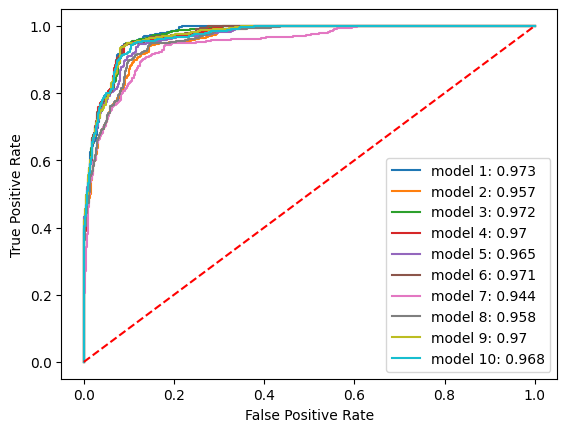

In [ ]:
auc_drop, avg_pred_drop = drop_synchronizing_ensemble(Autoencoder,96, 10, X_train, X_test, y_test, plot=True)

49/49 [==============================] - 0s 4ms/step


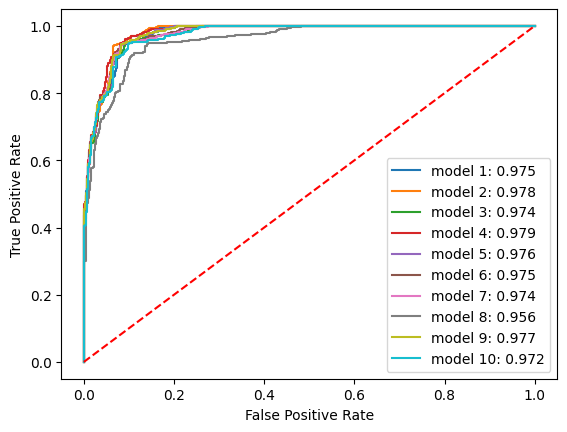

In [ ]:
auc_drop, avg_pred_drop = drop_synchronizing_ensemble(Autoencoder,112, 10, X_train, X_test, y_test, plot=True)

## 6.3. full_drop_synchronizing

only the prediction errors of the last trained model are used as features in the data used to train the next model. In this case, we keep the shape of prediction errors instead of reshape them to get only one feature

In [15]:
def full_drop_synchronizing_ensemble(model_architecture, latent, num_models, X_train, X_test, y_test, plot=True):
  """Create a syschronizing ensemble, in which the prediction errors of the last 
  trained model will be added as features to the original training data used for the next model.
  AUC score is calculated by using the error predictions of the last sychronized model

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    latent -- latent space size
    num_models -- the number of models which are integrated in one sychronizing ensemble model
    X_train -- data which are used to train the model
    X_test -- data which are used to validate the model
    plot -- draw ROC curve of all trained models in ensemble
         
  Returns: 
    auc_score_list -- AUC score lists of all models during sychronizing
    pred_errors_list -- list of pred_errors. Each element contains the all the difference between inputs and their predictions of one model
                            each element has shape (X_train.shape)
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  # list of pred_errors. Each element contains all the difference between inputs and their predictions of one model
  pred_errors_list = []
  test_errors_list = []
  auc_score_list = []
  X_plus_one = X_train.copy()
  X_test_one = X_test.copy()

  for i in range(num_models):
    # 1. Create model
    # if pred_errors_list is not empty, then we have to concatenate the element at position i to the current training input
    if pred_errors_list:
      # convert the element at position i-1 in pred_errors_list to a 2D-tensor and then convert it to a numpy array. 
      pred_current = tf.reshape(pred_errors_list[i-1], [X_train.shape[0], -1]).numpy()
      # only the prediction errors of the last model is concatenated to the original training data before training the next one
      X_plus_one = np.concatenate((X_train.copy(), pred_current), axis=1)
      # convert the element at position i-1 in test_errors_list to a 2D-tensor and then convert it to a numpy array. 
      pred_test_current = tf.reshape(test_errors_list[i-1], [X_test.shape[0], -1]).numpy()
      # concatenate the pred_current to X_test also. This new X_test will be used for later predict method   
      X_test_one = np.concatenate((X_test.copy(), pred_test_current), axis=1)
     
    # training model
    autoencoder, history = training_model(model_architecture, X_plus_one, X_test_one, latent = latent, verbose = 0, loss = "mse", epochs=50, batch_size=128)
    
    # getting predictions of the training data
    preds = autoencoder.predict(X_plus_one)
    # calculate the difference between preds and the training data using (input - preds)**2
    pred_errors = tf.math.square(tf.math.subtract(preds, X_plus_one))
    # append pred_errors to the avg_pred_errors_list
    pred_errors_list.append(pred_errors)

    # getting predictions (recontructions) of the test data
    preds_test = autoencoder.predict(X_test_one)
    # calculate the difference between preds and the test data using (input - preds)**2. These values is used to create a new feature added to the next training loop
    pred_errors_test = tf.math.square(tf.math.subtract(preds_test, X_test_one))
    # append avg_preds_test to the test_errors_list
    test_errors_list.append(pred_errors_test)

    # 4. Calculating AUC score of each training model
    # calculate the difference between pred_test and test data based on mean square error
    errors_test = tf.keras.losses.mse(preds_test, X_test_one)
    auc_score = round(roc_auc_score(y_test, errors_test), 3)
    auc_score_list.append(auc_score)

    # 5. Plot ROC Curve
    if plot:
      fpr, tpr, threshold = roc_curve(y_test, errors_test)
      plt.plot(fpr, tpr, label = f'model {i+1}: {auc_score}')
      
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  return auc_score_list, pred_errors_list

49/49 [==============================] - 0s 6ms/step


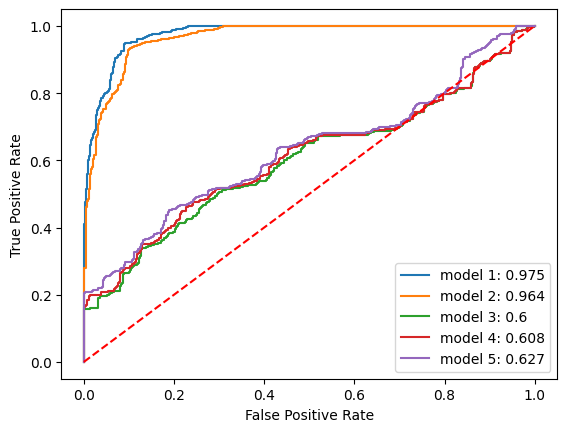

In [17]:
full_auc_score_list, full_pred_errors_list = full_drop_synchronizing_ensemble(Autoencoder, 112, 5, X_train, X_test, y_test, plot=True)

* When I try to change 10 models by using full_drop_synchronizing, it comes up with an error. The reason is that for each model, we add double features of the previous trained model. So it is a huge amount of features shoul be added to the next model. 
* I think one reason for the bad result, when we use `full_drop_synchronizing_ensemble` is because the original training set has a big amount of features (128). So each time we try to double it. when a model is trained by using so many features of training data, the result is bad